## VAE 코드 구현 연습

In [3]:
import torch

seed = 2023

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.FashionMNIST(
    root='.fashion_mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_dataset = datasets.FashionMNIST(
    root='.fashion_mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.49MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 109kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


torch.Size([64, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([3, 242, 242])


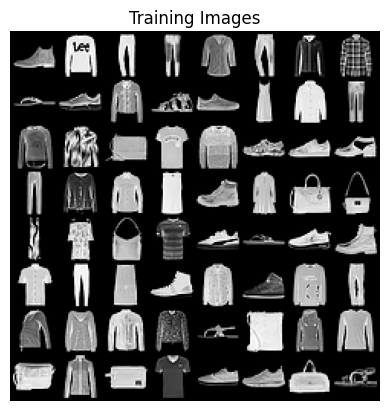

In [42]:
from torchvision import utils # 시각화를 위한 라이브러리
import matplotlib # 시각화를 위한 라이브러리
from matplotlib import pyplot as plt # 시각화를 위한 라이브러리
import numpy as np #numpy 데이터 형식을 다루기 위한 라이브러리

plt.axis('off')
plt.title("Training Images")

image = train_dataset.data[:64]
print(image.shape)
print(image.unsqueeze(1).shape)
grid = utils.make_grid(image.unsqueeze(1))
print(grid.shape)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [44]:
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()
        
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1) # (배치사이즈, 채널, 가로, 세로) => (배치사이즈, 채널 x 가로 x 세로)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 28 * 28)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = torch.sigmoid(self.fc3(z))
        x_hat = x_hat.view(z.size(0), 1, 28, 28)
        return x_hat

In [45]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

In [46]:
class VariationalEncoder(Encoder):
    def __init__(self, latent_dim=20):
        super().__init__(latent_dim=latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

    def foward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)

        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

In [48]:
class VariationalAutoencoder(Autoencoder):
    def __init__(self, encoder=VariationalEncoder, decoder=Decoder, latent_dim: int=16):
        super().__init__(latent_dim=latent_dim)
        self.encoder = encoder(latent_dim)

    def reparameterize(self, mean: torch.Tensor, log_var: torch.Tensor):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + (epsilon * std)

    def foward(self, x: torch.Tensor):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [54]:
import numpy as np

mean = 10
std = 5
N = 1000

In [59]:
dist_origin = np.random.normal(mean, std, N)
print(f"정규 분포에서 샘플링한 데이터의 평균은 {dist_origin.mean()} 입니다.")
print(f"정규 분포에서 샘플링한 데이터의 표준 편차는 {dist_origin.std()} 입니다.")

정규 분포에서 샘플링한 데이터의 평균은 9.9999667128843 입니다.
정규 분포에서 샘플링한 데이터의 표준 편차는 4.8953179266688025 입니다.


In [60]:
dist_reparam = mean + std*np.random.normal(0, 1, N)
print(f"재매개변수화를 적용한 데이터의 평균은 {dist_reparam.mean()} 입니다.")
print(f"재매개변수화를 적용한 데이터의 표준 편차는 {dist_reparam.std()} 입니다.")

재매개변수화를 적용한 데이터의 평균은 10.082031717469702 입니다.
재매개변수화를 적용한 데이터의 표준 편차는 5.036731352327362 입니다.


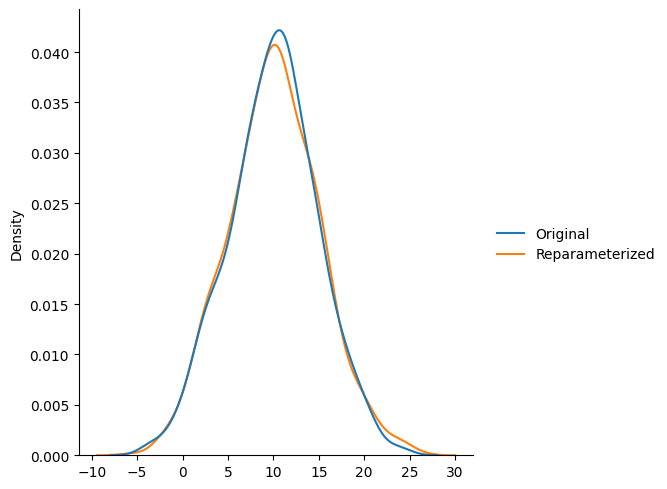

In [66]:
import seaborn as sns

sns.displot(
    {"Original": dist_origin, "Reparameterized": dist_reparam},
    kind="kde",
)
